# Challenge Description:

We have data about users who hit our site: whether they converted or not as well as some of their characteristics such as their country, the marketing channel, their age, whether they are repeat users and the number of pages visited during that session (as a proxy for site activity/time spent on site).

## Project goal
Your project is to:
1. Predict conversion rate

2. Come up with recommendations for the product team and the marketing team to improve conversion rate

## Data:

Columns:

country : user country based on the IP address

age : user age. Self-reported at sign-in step

new_user : whether the user created the account during this session or had already an account and simply came back to the site

source : marketing channel source
1. Ads: came to the site by clicking on an advertisement
2. Seo: came to the site by clicking on search results
3. Direct: came to the site by directly typing the URL on the browser

total_pages_visited: number of total pages visited during the session. This is a proxy for time spent on site and engagement during the session.
converted: this is our label. 1 means they converted within the session, 0 means they left without buying anything. 

The company goal is to increase conversion rate: # conversions / total sessions.

# Data exploration 

In [179]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import h2o
from h2o.frame import H2OFrame
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch

In [181]:
data = pd.read_csv('conversion_data.csv')

## General exploration

In [182]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [183]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316200 entries, 0 to 316199
Data columns (total 6 columns):
country                316200 non-null object
age                    316200 non-null int64
new_user               316200 non-null int64
source                 316200 non-null object
total_pages_visited    316200 non-null int64
converted              316200 non-null int64
dtypes: int64(4), object(2)
memory usage: 14.5+ MB


In [184]:
data.describe()

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


In [185]:
data.describe(include=['object']) # summary for categorical column

,country,source
count,316200,316200
unique,4,3
top,US,Seo
freq,178092,155040


In [186]:
for column in data.columns:
    uniques = sorted(data[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[:5])

country                  4	 ['China', 'Germany', 'UK', 'US']
age                     60	 [17, 18, 19, 20, 21]
new_user                 2	 [0, 1]
source                   3	 ['Ads', 'Direct', 'Seo']
total_pages_visited     29	 [1, 2, 3, 4, 5]
converted                2	 [0, 1]


## Remove Outliers

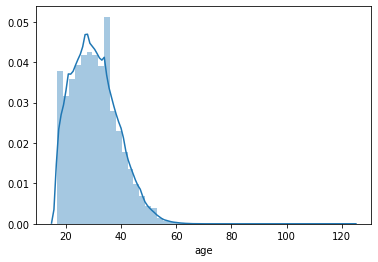

In [187]:
sns.distplot(data.age)

We can see from the plot that user base is pretty young. Also there are some outliers in age should be deleted.

In [188]:
sorted(data.age,reverse=True)[:10]

[123, 111, 79, 77, 73, 72, 70, 70, 69, 69]

In [189]:
#Remove Outliers, Since there are just 2 numbers above 80.
data = data[data['age']<80]

## Group by converted vs not converted.

In [190]:
total_conversion_rate = data['converted'].sum()/len(data)
total_conversion_rate

0.03225194340255157

In [191]:
sizes_convert = data['converted'].value_counts()
data['converted'].value_counts(normalize=True)

0    0.967748
1    0.032252
Name: converted, dtype: float64

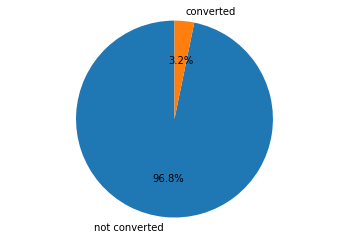

In [192]:
# pie chart of converted vs unconverted
fig1, ax1 = plt.subplots()
ax1.pie(sizes_convert,labels= ['not converted','converted'],autopct='%1.1f%%',startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Conversion rate at around 3% is industry standard.

##  Group by country 

In [197]:
sizes = data['country'].value_counts()
sizes

US         178092
China       76602
UK          48449
Germany     13055
Name: country, dtype: int64

In [198]:
data['country'].value_counts(normalize=True)

US         0.563229
China      0.242260
UK         0.153224
Germany    0.041287
Name: country, dtype: float64

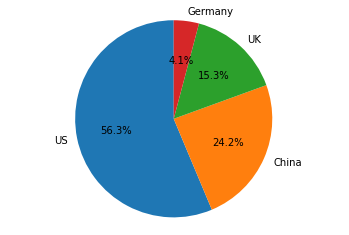

In [199]:
fig1, ax1 = plt.subplots()
ax1.pie(sizes,labels= ['US','China','UK','Germany'],autopct='%1.1f%%',startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [200]:
data[['country', 'converted']].groupby('country').mean().reset_index()

,country,converted
0,China,0.001332
1,Germany,0.062428
2,UK,0.052612
3,US,0.037801


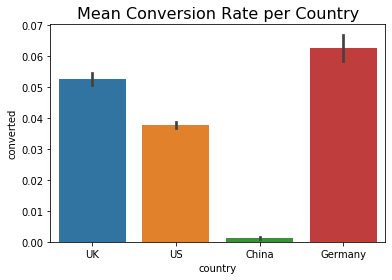

In [201]:
sns.barplot(x='country', y='converted', data=data).set_title('Mean Conversion Rate per Country', fontsize=16)
plt.show()

The site is working very well for Germany in terms of conversion. But the summary showed that there are few Germans coming to the site: way less than UK, despite a larger population. Again, marketing should get more Germans. Big opportunity.

China convert at a much lower rate than other countries. Maybe Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the local culture, some payment issue or maybe it is just in English! Given how many users are based in China, fixing this should be a top priority. Huge opportunity.

## Group by user type 

In [202]:
sizes_user = data['new_user'].value_counts()
data['new_user'].value_counts(normalize=True)

1    0.685469
0    0.314531
Name: new_user, dtype: float64

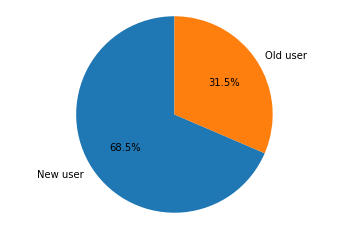

In [203]:
fig1, ax1 = plt.subplots()
ax1.pie(sizes_user,labels= ['New user','Old user'],autopct='%1.1f%%',startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [204]:
data[['new_user', 'converted']].groupby('new_user').mean().reset_index()

,new_user,converted
0,0,0.071983
1,1,0.014021


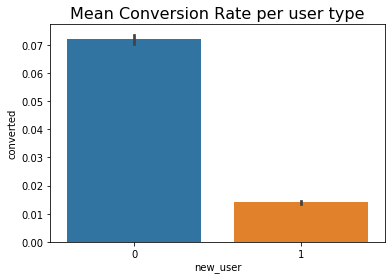

In [205]:
sns.barplot(x='new_user', y='converted', data=data).set_title('Mean Conversion Rate per user type', fontsize=16)
plt.show()

Users with old accounts do much better. Targeted emails with offers to bring them back to the site could be a good idea to try.

## Group by source

In [206]:
sizes_source = data['source'].value_counts()
data['source'].value_counts(normalize=True)

Seo       0.490323
Ads       0.280644
Direct    0.229034
Name: source, dtype: float64

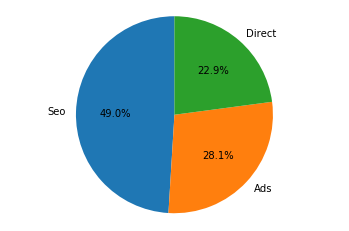

In [207]:
fig1, ax1 = plt.subplots()
ax1.pie(sizes_source,labels= ['Seo','Ads','Direct'],autopct='%1.1f%%',startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [36]:
data[['source', 'converted']].groupby('source').mean().reset_index()

,source,converted
0,Ads,0.034472
1,Direct,0.028169
2,Seo,0.032888


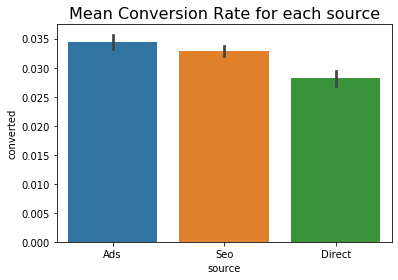

In [209]:
sns.barplot(x='source', y='converted', data=data).set_title('Mean Conversion Rate for each source', fontsize=16)
plt.show()

Conversion rate for each source are similar.

## Group by age

In [43]:
age_group = data[['age', 'converted']].groupby('age').mean().reset_index()
age_group.head()

,age,converted
0,17,0.071607
1,18,0.066029
2,19,0.058616
3,20,0.057109
4,21,0.053985


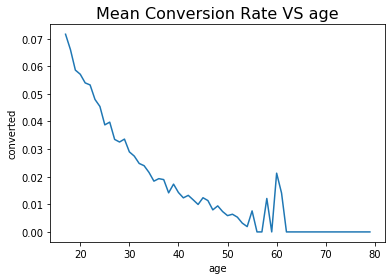

In [52]:
sns.lineplot(data = age_group, x='age',y='converted').set_title('Mean Conversion Rate VS age', fontsize=16)
plt.show()

The site is working very well for young users. Definitely let’s tell marketing to advertise and use marketing channel which are more likely to reach young people.

Maybe go through the UI and figure out why older users perform so poorly? From 30 y/o conversion clearly starts dropping.

## Group by total pages visited.

In [54]:
page_visit_group = data[['total_pages_visited', 'converted']].groupby('total_pages_visited').mean().reset_index()
page_visit_group.head()

,total_pages_visited,converted
0,1,0.000000
1,2,0.000228
2,3,0.000251
3,4,0.000780
4,5,0.001570


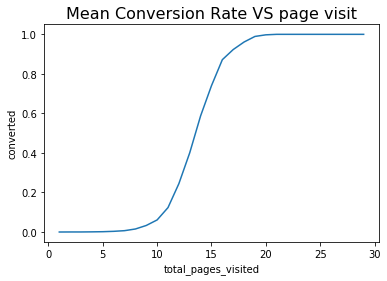

In [56]:
sns.lineplot(data = page_visit_group, x='total_pages_visited',y='converted').set_title('Mean Conversion Rate VS page visit', fontsize=16)
plt.show()

More pages visited implies higher conversion rate. 

If I know someone has visited many pages, but hasn’t converted, she almost surely has high purchase intent. I could email her targeted offers or sending her reminders. Overall, these are probably the easiest users to make convert.

# Build ML models

Next step:
Build ML model to predict conversion rate (whether an user is converted or not). This is a classification problem.

We will try
1. logistic model
2. logistic model with regularization 
3. random forest model

## Data preperation

In [84]:
# Split into 75% training and 25% test dataset
train, test = h2o_df.split_frame(ratios = [0.8], seed = 1234)
feature = ['country', 'age', 'new_user', 'source', 'total_pages_visited']
target = 'converted'

In [78]:
# Initialize H2O cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_261"; Java(TM) SE Runtime Environment (build 1.8.0_261-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.261-b12, mixed mode)
  Starting server from /Users/opheliaming/opt/anaconda3/envs/py37/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/70/03x2hqsd6hlbxgztv4sps06m0000gn/T/tmp6e_ikxyx
  JVM stdout: /var/folders/70/03x2hqsd6hlbxgztv4sps06m0000gn/T/tmp6e_ikxyx/h2o_opheliaming_started_from_python.out
  JVM stderr: /var/folders/70/03x2hqsd6hlbxgztv4sps06m0000gn/T/tmp6e_ikxyx/h2o_opheliaming_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,08 secs
H2O_cluster_timezone:,Europe/Amsterdam
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.2
H2O_cluster_version_age:,27 days
H2O_cluster_name:,H2O_from_python_opheliaming_jdndet
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.556 Gb
H2O_cluster_total_cores:,0
H2O_cluster_allowed_cores:,0
H2O_cluster_status:,"accepting new members, healthy"


In [83]:
# Transform to H2O Frame, and make sure the target variable which contains integer (e.g. 0,1) are categorical
h2o_df = H2OFrame(data)
h2o_df['new_user'] = h2o_df['new_user'].asfactor()
h2o_df['converted'] = h2o_df['converted'].asfactor()
h2o_df.summary()

Parse progress: |█████████████████████████████████████████████████████████| 100%


,country,age,new_user,source,total_pages_visited,converted
type,enum,int,enum,enum,int,enum
mins,,17.0,,,1.0,
mean,,30.56931100133461,,,4.872918234777001,
maxs,,79.0,,,29.0,
sigma,,8.268957596421435,,,3.3410533442156285,
zeros,,0,,,0,
missing,0,0,0,0,0,0
0,UK,25.0,1,Ads,1.0,0
1,US,23.0,1,Seo,5.0,0
2,US,28.0,1,Seo,4.0,0


## Logistic regression 

In [108]:
lr_model = H2OGeneralizedLinearEstimator(family= "binomial",
                                          lambda_ = 0, # No Regularization
                                          compute_p_values = True)
lr_model.train(feature, target, training_frame= train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [109]:
lr_model._model_json['output']['coefficients_table']


Coefficients: glm coefficients


,names,coefficients,std_error,z_value,p_value,standardized_coefficients
0,Intercept,-10.448601,0.171569,-60.900305,0.000000,-8.974405
1,country.Germany,3.923337,0.151383,25.916637,0.000000,3.923337
2,country.UK,3.721586,0.138539,26.863082,0.000000,3.721586
3,country.US,3.361179,0.134622,24.967453,0.000000,3.361179
4,source.Direct,-0.205178,0.054313,-3.777681,0.000158,-0.205178
5,source.Seo,-0.041698,0.044240,-0.942527,0.345923,-0.041698
6,new_user.1,-1.750315,0.039674,-44.117463,0.000000,-1.750315
7,age,-0.072545,0.002641,-27.472491,0.000000,-0.600135
8,total_pages_visited,0.757040,0.006916,109.463993,0.000000,2.533483


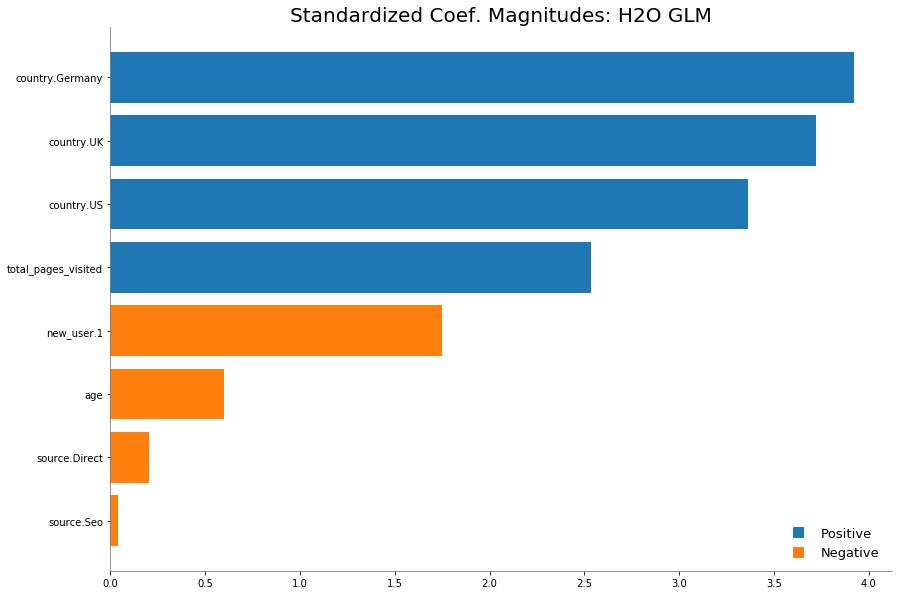

In [110]:
lr_model.std_coef_plot()

In [111]:
lr_perf = lr_model.model_performance(test)
lr_perf


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.010622923588474172
RMSE: 0.10306756807295965
LogLoss: 0.03962388892393442
Null degrees of freedom: 63049
Residual degrees of freedom: 63041
Null deviance: 17550.166988880163
Residual deviance: 4996.572393308125
AIC: 5014.572393308125
AUC: 0.9862337019660359
AUCPR: 0.8418000719769683
Gini: 0.9724674039320718

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37605823382520004: 


,,0,1,Error,Rate
0,0,60678.0,400.0,0.0065,(400.0/61078.0)
1,1,487.0,1485.0,0.247,(487.0/1972.0)
2,Total,61165.0,1885.0,0.0141,(887.0/63050.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.376058,0.770029,180.0
1,max f2,0.143463,0.791287,254.0
2,max f0point5,0.673156,0.824918,105.0
3,max accuracy,0.447998,0.986328,160.0
4,max precision,0.999609,1.000000,0.0
5,max recall,0.000023,1.000000,399.0
6,max specificity,0.999609,1.000000,0.0
7,max absolute_mcc,0.401837,0.763008,173.0
8,max min_per_class_accuracy,0.031686,0.940420,328.0
9,max mean_per_class_accuracy,0.043531,0.941474,317.0



Gains/Lift Table: Avg response rate:  3.13 %, avg score:  9.12 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010151,0.166950,0.000000,0.000000,0.000000,0.171114,0.000000,0.171114,0.000000,0.000000,-100.000000,-100.000000,-0.010478
1,2,0.020159,0.164238,0.000000,0.000000,0.000000,0.165341,0.000000,0.168248,0.000000,0.000000,-100.000000,-100.000000,-0.020809
2,3,0.030389,0.162412,0.000000,0.000000,0.000000,0.163167,0.000000,0.166538,0.000000,0.000000,-100.000000,-100.000000,-0.031370
3,4,0.040032,0.161233,0.000000,0.000000,0.000000,0.161750,0.000000,0.165384,0.000000,0.000000,-100.000000,-100.000000,-0.041324
4,5,0.050008,0.159930,0.000000,0.000000,0.000000,0.160695,0.000000,0.164449,0.000000,0.000000,-100.000000,-100.000000,-0.051623
5,6,0.100222,0.154683,0.000000,0.000000,0.000000,0.157161,0.000000,0.160798,0.000000,0.000000,-100.000000,-100.000000,-0.103458
6,7,0.150087,0.149792,0.000000,0.000000,0.000000,0.152232,0.000000,0.157952,0.000000,0.000000,-100.000000,-100.000000,-0.154933
7,8,0.200127,0.144435,0.020268,0.005068,0.000634,0.147231,0.000159,0.155271,0.001014,0.001014,-97.973210,-99.493222,-0.205541
8,9,0.300032,0.093876,0.553265,0.187607,0.017304,0.118398,0.005868,0.142993,0.055274,0.056288,-44.673516,-81.239306,-0.251613
9,10,0.400650,0.084573,0.655177,0.305031,0.020492,0.088576,0.009540,0.129327,0.065923,0.122211,-34.482343,-69.496850,-0.287429


In [112]:
lr_perf.accuracy()

[[0.447997783486459, 0.9863283108643933]]

## Logistic regression with L2 Regularization 

In [128]:
# logistic regression with L2 Regularization 
lr_model_1 = H2OGeneralizedLinearEstimator(family= "binomial",
                                           alpha = 0) # alpha=0: ridge, alpha = 1:lasso
lr_model_1.train(feature, target, training_frame= train)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [129]:
lr_model_1._model_json['output']['coefficients_table']


Coefficients: glm coefficients


,names,coefficients,standardized_coefficients
0,Intercept,-8.394576,-6.941118
1,country.China,-2.179177,-2.179177
2,country.Germany,0.913886,0.913886
3,country.UK,0.799079,0.799079
4,country.US,0.466212,0.466212
5,source.Ads,0.077073,0.077073
6,source.Direct,-0.116268,-0.116268
7,source.Seo,0.039195,0.039195
8,new_user.0,0.848979,0.848979
9,new_user.1,-0.848979,-0.848979


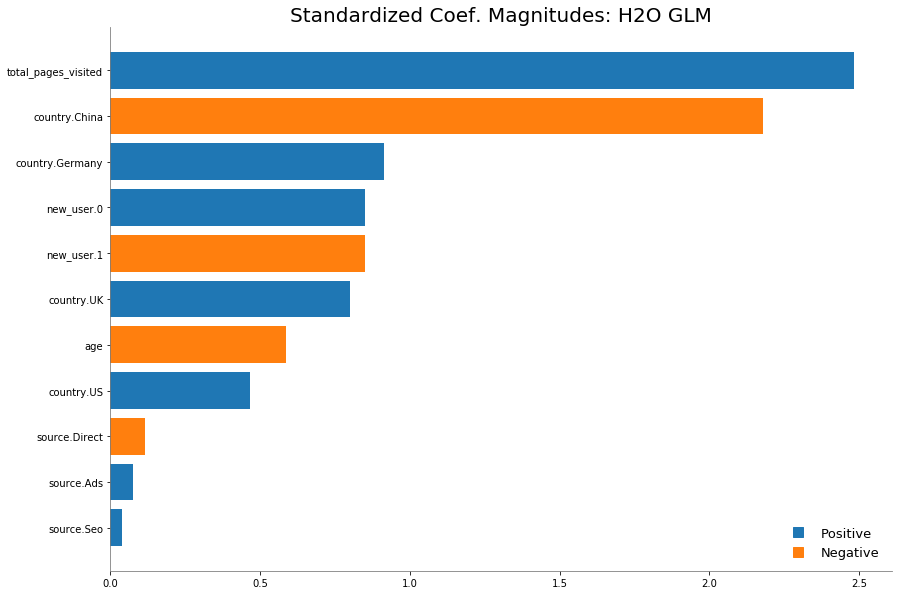

In [131]:
lr_model_1.std_coef_plot()

In [135]:
# logistic regression with L1 Regularization 
lr_model_2 = H2OGeneralizedLinearEstimator(family= "binomial",
                                           alpha = 1) # alpha=0: ridge, alpha = 1:lasso
lr_model_2.train(feature, target, training_frame= train)
lr_model_2._model_json['output']['coefficients_table']
lr_model_2._model_json['output']['coefficients_table']

glm Model Build progress: |███████████████████████████████████████████████| 100%

Coefficients: glm coefficients


,names,coefficients,standardized_coefficients
0,Intercept,-7.829804,-6.337811
1,country.China,-2.931531,-2.931531
2,country.Germany,0.419341,0.419341
3,country.UK,0.308781,0.308781
4,country.US,0.000000,0.000000
5,source.Ads,0.011320,0.011320
6,source.Direct,-0.122175,-0.122175
7,source.Seo,0.000000,0.000000
8,new_user.0,0.733714,0.733714
9,new_user.1,-0.966985,-0.966985


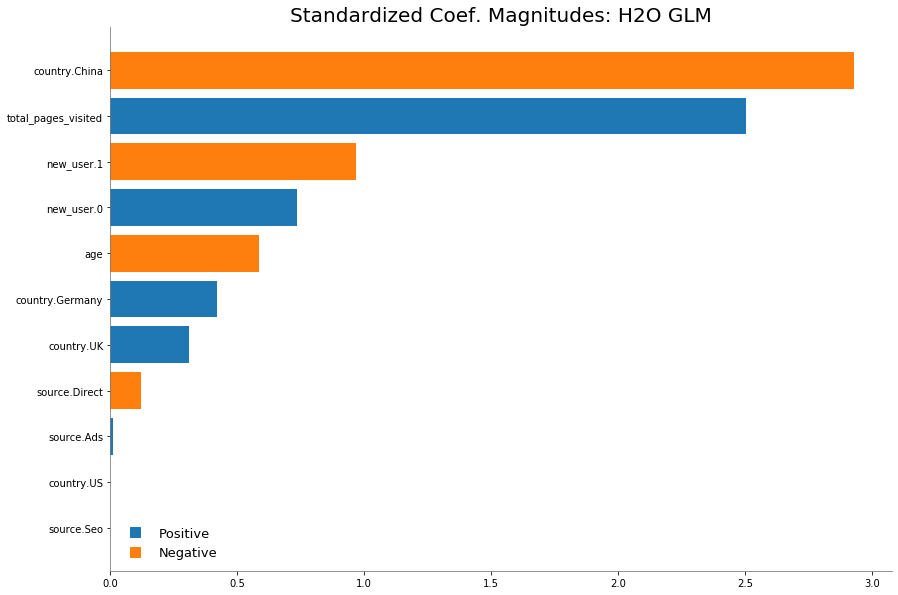

In [136]:
lr_model_2.std_coef_plot()

In [130]:
lr_model_1._model_json['output']['coefficients_table']
lr_perf_1 = lr_model_1.model_performance(test)
#lr_perf_1
lr_perf_1.accuracy()

[[0.4402139152243448, 0.986375892149088]]

## Random forest model

I am going to pick a random forest to predict conversion rate. 

I pick a random forest cause:
1. it usually requires very little time to optimize it (its default params are often close to the best ones)
2. it is strong with outliers, irrelevant variables, continuous and discrete variables. 
3. I can use its partial dependence plots and variable importance to get insights about how it got information from the variables. 

In [85]:
# Build random forest model
model = H2ORandomForestEstimator(balance_classes=True, ntrees=100, max_depth=20, 
                                 mtries=-1, seed=42, score_each_iteration=True)
model.train(x=feature, y=target, training_frame=train)

drf Model Build progress: |███████████████████████████████████████████████| 100%


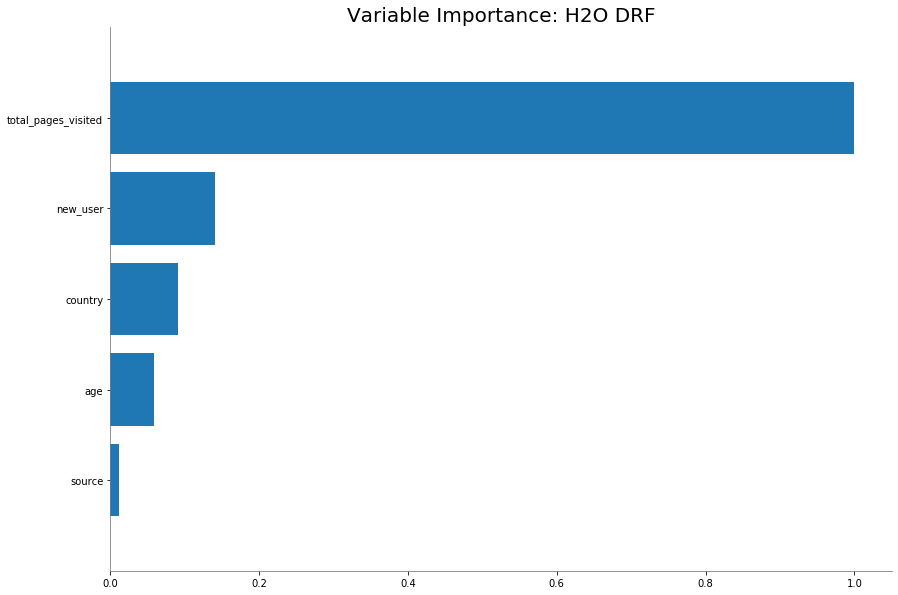

In [86]:
# feature importance 
perf = model.model_performance(test)
perf

Total pages visited is the most important one, by far. 
Unfortunately, it is probably the least “actionable”. People visit many pages cause they already want to buy. Also, in order to buy you have to click on multiple pages.

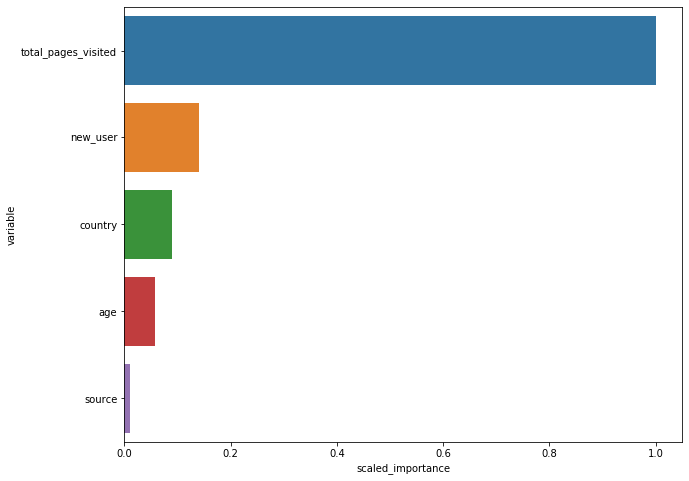

In [87]:
# Feature importance with color
importance = model.varimp(use_pandas=True)

fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x='scaled_importance', y='variable', data=importance)
plt.show()

In [89]:
# retrive model performance
perf = model.model_performance(test)
perf


ModelMetricsBinomial: drf
** Reported on test data. **

MSE: 0.012732058132027504
RMSE: 0.11283642201003852
LogLoss: 0.05161657745255575
Mean Per-Class Error: 0.08662425434520693
AUC: 0.9762785118247694
AUCPR: 0.7658677633267427
Gini: 0.9525570236495389

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33728551602955564: 


,,0,1,Error,Rate
0,0,60664.0,414.0,0.0068,(414.0/61078.0)
1,1,579.0,1393.0,0.2936,(579.0/1972.0)
2,Total,61243.0,1807.0,0.0157,(993.0/63050.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.337286,0.737232,196.0
1,max f2,0.151132,0.744028,259.0
2,max f0point5,0.486586,0.794185,151.0
3,max accuracy,0.462148,0.985155,159.0
4,max precision,0.994978,1.000000,0.0
5,max recall,0.000040,1.000000,399.0
6,max specificity,0.994978,1.000000,0.0
7,max absolute_mcc,0.462148,0.731846,159.0
8,max min_per_class_accuracy,0.010494,0.905334,361.0
9,max mean_per_class_accuracy,0.004121,0.913376,375.0



Gains/Lift Table: Avg response rate:  3.13 %, avg score:  2.68 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010008,0.818145,29.692478,29.692478,0.928685,0.905881,0.928685,0.905881,0.297160,0.297160,2869.247757,2869.247757,0.296423
1,2,0.020000,0.586533,26.187096,27.941176,0.819048,0.708876,0.873910,0.807457,0.261663,0.558824,2518.709553,2694.117647,0.556220
2,3,0.030008,0.304510,15.960973,23.945665,0.499208,0.440817,0.748943,0.685179,0.159736,0.718560,1496.097344,2294.566478,0.710783
3,4,0.040063,0.151018,6.656759,19.606327,0.208202,0.215805,0.613222,0.567371,0.066937,0.785497,565.675930,1860.632746,0.769501
4,5,0.050056,0.089684,3.654013,16.421930,0.114286,0.112469,0.513625,0.476563,0.036511,0.822008,265.401333,1542.193015,0.796876
5,6,0.100143,0.017431,1.366784,8.891973,0.042749,0.040729,0.278112,0.258577,0.068458,0.890467,36.678380,789.197257,0.815841
6,7,0.150024,0.004922,1.169110,6.324217,0.036566,0.009693,0.197801,0.175826,0.058316,0.948783,16.910999,532.421670,0.824548
7,8,0.200333,0.001507,0.544301,4.872717,0.017024,0.002685,0.152403,0.132345,0.027383,0.976166,-45.569946,387.271689,0.800882
8,9,0.300095,0.000793,0.132160,3.296791,0.004134,0.001044,0.103113,0.088696,0.013185,0.989351,-86.783974,229.679061,0.711509
9,10,0.400539,0.000566,0.030291,2.477644,0.000947,0.000666,0.077493,0.066621,0.003043,0.992394,-96.970856,147.764357,0.610963


1. Test error is low 1.6% so we are not overfitting.
2. If we cared about the very best possible accuracy or specifically minimizing false positive/false negative, we would also use ROCR and find the best cut-off point (threshold)

In [90]:
perf.F1()

[[0.33728551602955564, 0.7372320719767133]]

In [91]:
perf.accuracy()

[[0.46214822180077075, 0.9851546391752577]]

We started from a 96.8% accuracy (that’s the case if we classified everything as “non converted”).

So, 98.5% is good, but nothing shocking. 

In [92]:
perf.auc()

0.9762785118247694

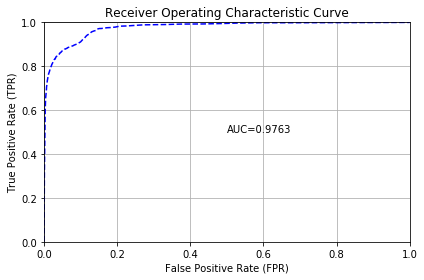

In [93]:
perf.plot(type = "roc")

In [212]:
# Shutdown h2o instance
h2o.cluster().shutdown()

H2O session _sid_8ca9 closed.


# Conclusions & suggestions:
1. The site is working very well for young users. Definitely let’s tell marketing to advertise and use
marketing channel which are more likely to reach young people.
2. The site is working very well for Germany in terms of conversion. But the summary showed that
there are few Germans coming to the site: way less than UK, despite a larger population. Again,
marketing should get more Germans. Big opportunity.
3. Users with old accounts do much better. Targeted emails with offers to bring them back to the site
could be a good idea to try.
4. Something is wrong with the Chinese version of the site. It is either poorly translated, doesn’t fit the
local culture, some payment issue or maybe it is just in English! Given how many users are based in
China, fixing this should be a top priority. Huge opportunity.
5. Maybe go through the UI and figure out why older users perform so poorly? From 30 y/o conversion
clearly starts dropping.
6. If I know someone has visited many pages, but hasn’t converted, she almost surely has high
purchase intent. I could email her targeted offers or sending her reminders. Overall, these are
probably the easiest users to make convert.


As you can see, conclusions usually end up being about:
1. tell marketing to get more of the good performing user segments
2. tell product to fix the experience for the bad performing ones